In [1]:
from Hierarchy.PipelineFunctions.MainWorkers import times_when_method_better, MakeDendogram, generator, RunExperiment, ReadLogs
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import pickle

/var/folders/7g/1dqbz5hx5994z2r91kw1_k2m0000gn/T/ipykernel_58148/2474083448.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def generation(size, dim):
    norm_dist = sts.norm(0, 1000)
    x = norm_dist.rvs(size).astype(int)

    if dim == 1:
        y = np.zeros(len(x))
    elif dim == 2:
        y = norm_dist.rvs(size).astype(int)

    points = list(zip(x, y))
    points = np.unique(points, axis=0)
    
    return np.array(points)

In [3]:
sample_size = 6
iter_number = 100
dim = 2
file_name = generator(generation, 1000, sample_size, iter_number, dim)

In [4]:
# file_name = './LOGS/1dim-5-10.0k 2023-04-26 23:34:04/Samples'

# dim = int(file_name[7:8])
# sample_size = int(file_name[12:13])

# iter_number_def = file_name.split()[0][14:]

# if 'k' in iter_number_def:
#     iter_number = int(float(iter_number_def[:-1])) * 1000
# else:
#     iter_number = int(float(iter_number_def))

In [5]:
file_samples = open(file_name, 'rb')
Samples = pickle.load(file_samples)

In [6]:
for dist_metric in ('euclidean', 'cityblock', 'chebyshev'):
    RunExperiment(dist_metric, file_name[:-8], Samples)

100%|██████████| 100/100 [00:01<00:00, 79.39it/s]


In [15]:
# ПРОВЕРКА НА МОНОТОННОСТЬ
for file_ultra in (f"{file_name[:-8]}/{name}" for name in ('euclidean', 'cityblock', 'chebyshev')):
    TimeLogsList, Ultradists, MaxList, SumList, NameOfMethodList, NormDiff = ReadLogs(file_ultra)
    flag = 0
    for num, ultra in enumerate(Ultradists):
        if sorted(ultra) != ultra:
            display(HTML(f'<h4> The methods in {file_ultra}</h4>'))
            print(f"Пример номер {NameOfMethodList[num]}: {num}")
            print(ultra)
            print()
            flag = 1
    if flag != 1:
        display(HTML(f'<h4> The methods in {file_ultra} is monotonous</h4>'))

In [16]:
ResultsForMaxList = {}
ResultsForSumList = {}
for dist_metric in ('euclidean', 'cityblock', 'chebyshev'):
    dist_metric_dir = f"{file_name[:-8]}/{dist_metric}"
    
    TimeLogsList, Ultradists, MaxList, SumList, NameOfMethodList, NormDiff = ReadLogs(dist_metric_dir)

    MaxMatrix = pd.DataFrame({'MetricsByMethodsForMax': MaxList, 'NameOfMethod': NameOfMethodList})
    grouper = MaxMatrix.groupby('NameOfMethod')
    ResultsForMax = pd.concat([pd.Series(v['MetricsByMethodsForMax'].tolist(), name=k) for k, v in grouper], axis=1)
    ResultsForMaxList[dist_metric] = ResultsForMax

    SumMatrix = pd.DataFrame({'MetricsByMethodsForSum': SumList, 'NameOfMethod': NameOfMethodList})
    grouper = SumMatrix.groupby('NameOfMethod')
    ResultsForSum = pd.concat([pd.Series(v['MetricsByMethodsForSum'].tolist(), name=k) for k, v in grouper], axis=1)
    ResultsForSumList[dist_metric] = ResultsForSum

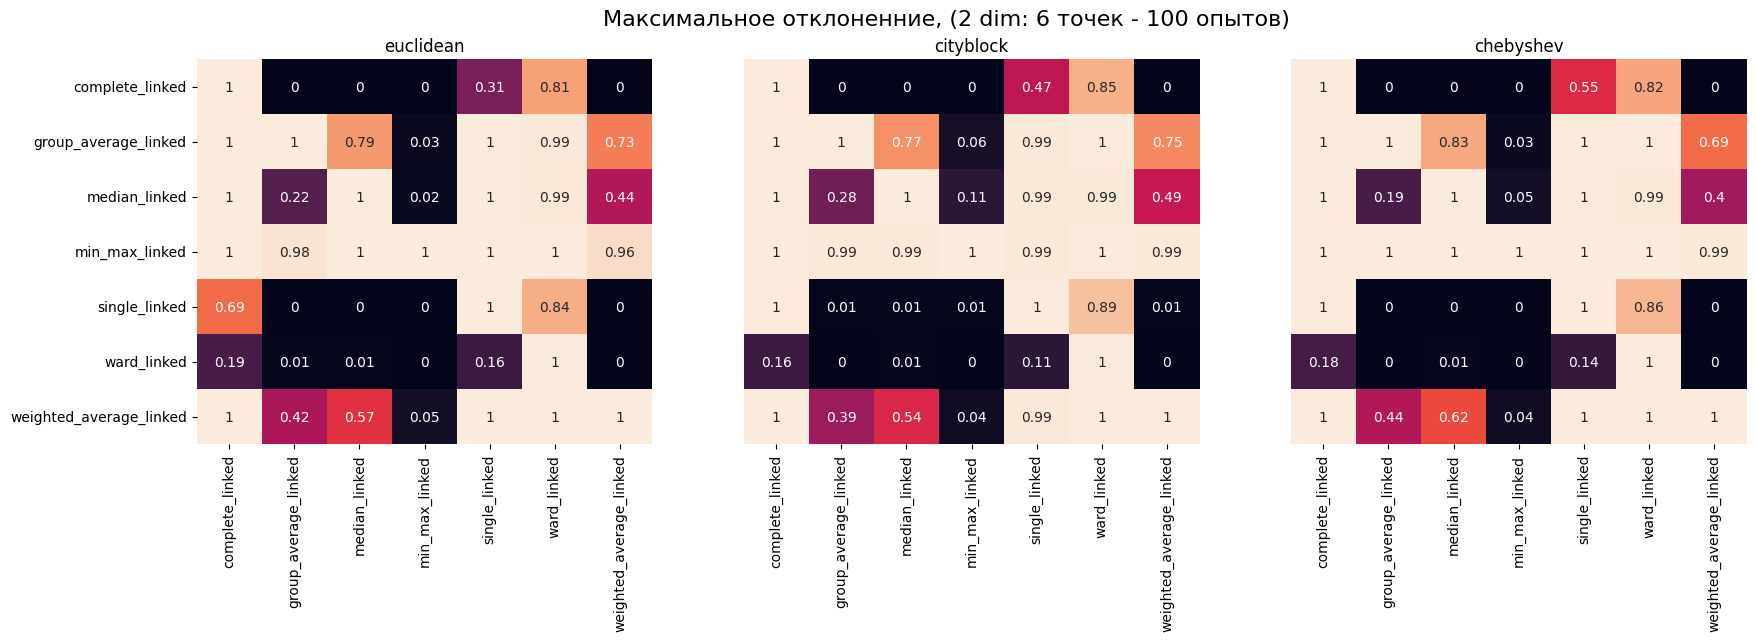

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,5))

for k, (dist_metric, resmax) in enumerate(ResultsForMaxList.items()):
    if k == 0:
        sns.heatmap(data=times_when_method_better(resmax), ax=axes[k], annot=True, cbar=False)
        axes[k].set_title(dist_metric)
    else:
        sns.heatmap(data=times_when_method_better(resmax), ax=axes[k], annot=True, cbar=False, yticklabels=False)
        axes[k].set_title(dist_metric)

fig.suptitle(f'Максимальное отклоненние, ({dim} dim: {sample_size} точек - {iter_number} опытов)', fontsize=16)
plt.show()

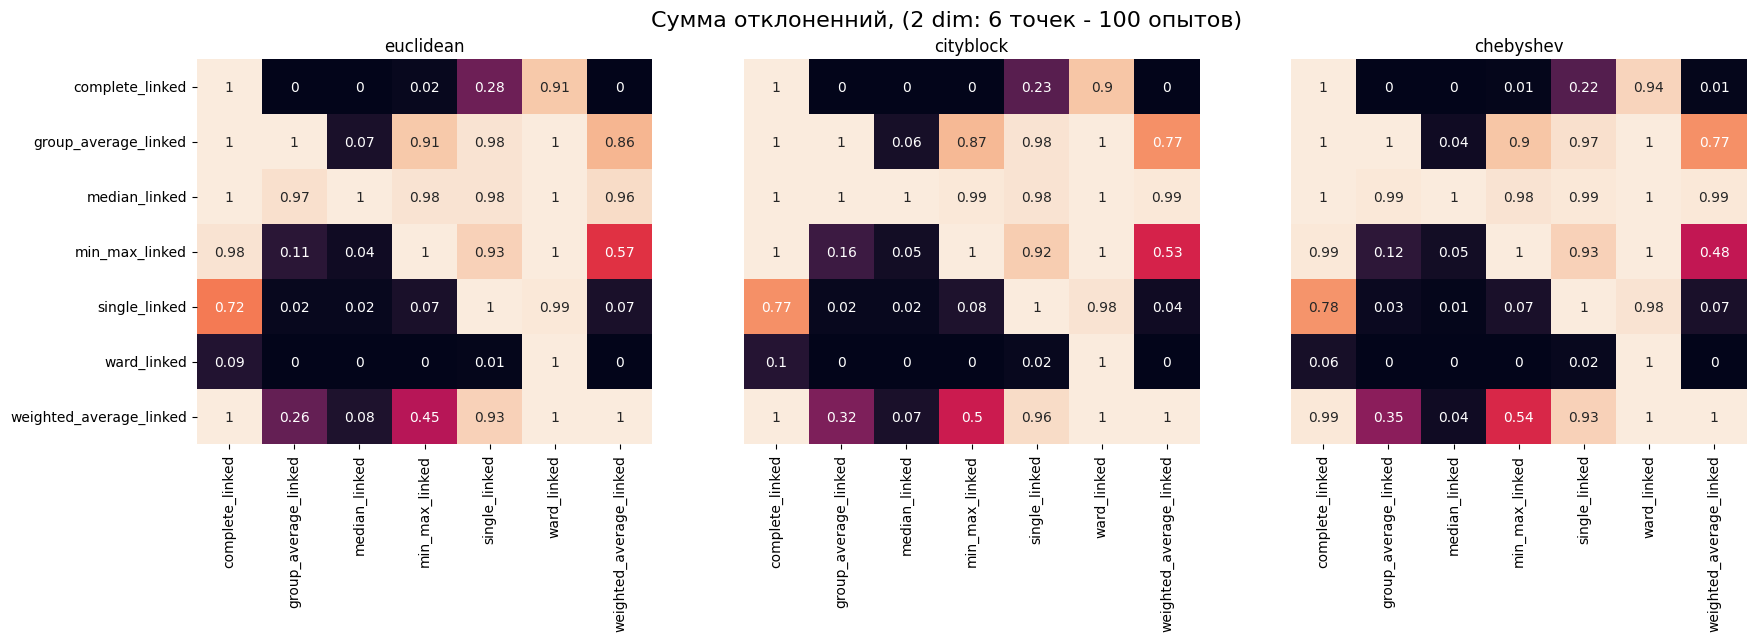

In [18]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,5))

for k, (dist_metric, ressum) in enumerate(ResultsForSumList.items()):
    if k == 0:
        sns.heatmap(data=times_when_method_better(ressum), ax=axes[k], annot=True, cbar=False)
        axes[k].set_title(dist_metric)
    else:
        sns.heatmap(data=times_when_method_better(ressum), ax=axes[k], annot=True, cbar=False, yticklabels=False)
        axes[k].set_title(dist_metric)

fig.suptitle(f'Сумма отклоненний, ({dim} dim: {sample_size} точек - {iter_number} опытов)', fontsize=16)
plt.show()

In [19]:
print("Метрика Максимального отклонения: случаи когда min_max_linked больше другого метода\n")
for dist_metric, resmax in ResultsForMaxList.items():
    print(dist_metric.upper())
    flag = 0
    for col in resmax.columns:
        exp = list(resmax.query(f'min_max_linked > {col}').index)
        if len(exp) != 0:
            print(f"{col}: {exp}\n")
            flag += 1

    if flag == 0:
        print("Случаев не обнаружено\n")

Метрика Максимального отклонения: случаи когда min_max_linked больше другого метода

EUCLIDEAN
group_average_linked: [45, 70]

weighted_average_linked: [3, 12, 45, 70]

CITYBLOCK
group_average_linked: [62]

median_linked: [22]

single_linked: [70]

weighted_average_linked: [21]

CHEBYSHEV
weighted_average_linked: [3]



In [20]:
print("Метрика Суммы отклонений: случаи когда median_linked больше другого метода\n")
for dist_metric, ressum in ResultsForSumList.items():
    print(dist_metric.upper())
    flag = 0
    for col in ressum.columns:
        exp = list(ressum.query(f'median_linked > {col}').index)
        if len(exp) != 0:
            print(f"{col}: {exp}\n")
            flag += 1

    if flag == 0:
        print("Случаев не обнаружено\n")

Метрика Суммы отклонений: случаи когда median_linked больше другого метода

EUCLIDEAN
group_average_linked: [0, 42, 66]

min_max_linked: [0, 42]

single_linked: [0, 70]

weighted_average_linked: [0, 3, 42, 66]

CITYBLOCK
min_max_linked: [3]

single_linked: [21, 70]

weighted_average_linked: [21]

CHEBYSHEV
group_average_linked: [78]

min_max_linked: [59, 78]

single_linked: [7]

weighted_average_linked: [32]



## Анализ

In [10]:
test_data = Samples[99]
pd.DataFrame(test_data, columns=['x', 'y'])

,x,y
0,768,-463
1,-472,710
2,893,-1490
3,-2021,-591
4,1065,755
5,112,-251


In [24]:
from Hierarchy.MedianMethod import MedianHierarchy
from Hierarchy.MinMaxMethod import MinMaxHierarchy
from Hierarchy.StandartMethods import hierarchy
from Hierarchy.ToCulcMethods.Linkages import single_linked, complete_linked, group_average_linked, weighted_average_linked, ward_linked

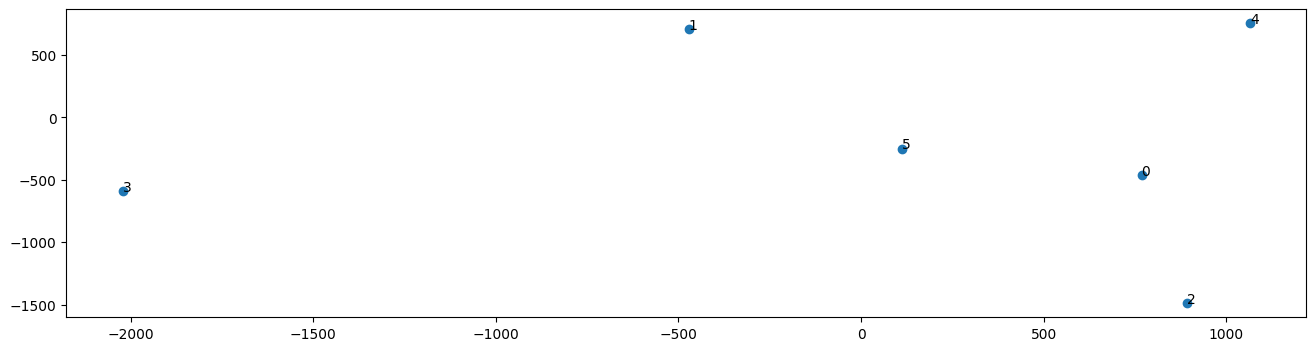

In [11]:
fig = plt.figure()
fig.set_size_inches(16, 4)
plt.scatter(test_data[:, 0], test_data[:, 1])

for i in range(len(test_data)):
    plt.text(test_data[i][0], test_data[i][1] + 0.005, str(i))

In [ ]:
# ('euclidean', 'cityblock', 'chebyshev'):
output1 = MinMaxHierarchy(test_data, logs_turn_on=True, metric='euclidean')
# MedianHierarchy(test_data, logs_turn_on=True, metric='euclidean')
output1

In [ ]:
MakeDendogram(test_data, output1[2])

In [25]:
output2 = hierarchy(test_data, metric='euclidean', method=ward_linked, logs_turn_on=True)
output2

Distance matrix: 0 step
             0            1            2            3            4  \
0     0.000000  1706.906266  1034.579141  2791.935708  1253.687760   
1  1706.906266     0.000000  2589.058709  2022.869744  1537.658610   
2  1034.579141  2589.058709     0.000000  3049.524061  2251.579224   
3  2791.935708  2022.869744  3049.524061     0.000000  3366.765807   
4  1253.687760  1537.658610  2251.579224  3366.765807     0.000000   
5   689.405541  1124.534126  1464.609846  2159.928008  1385.729050   

             5  
0   689.405541  
1  1124.534126  
2  1464.609846  
3  2159.928008  
4  1385.729050  
5     0.000000  

Clusters:['0' '1' '2' '3' '4' '5']


('Clusters:', array(['(0, 5)', '1', '2', '3', '4'], dtype='<U30'))
Distance matrix: 1 step
             (0, 5)            1            2            3            4
(0, 5)     0.000000  1657.825081  1436.324144  3071.440631  1529.809360
1       1657.825081     0.000000  2589.058709  2022.869744  1537.658610
2       1436.324144  

((((1, 4), ((0, 5), 2)), 3),
 array([[   0.        , 1706.90626573, 1034.57914149, 2791.93570843,
         1253.68776017,  689.40554103],
        [1706.90626573,    0.        , 2589.05870926, 2022.86974371,
         1537.65860971, 1124.53412576],
        [1034.57914149, 2589.05870926,    0.        , 3049.52406123,
         2251.57922357, 1464.60984566],
        [2791.93570843, 2022.86974371, 3049.52406123,    0.        ,
         3366.76580712, 2159.92800806],
        [1253.68776017, 1537.65860971, 2251.57922357, 3366.76580712,
            0.        , 1385.72904999],
        [ 689.40554103, 1124.53412576, 1464.60984566, 2159.92800806,
         1385.72904999,    0.        ]]),
 [689.4055410279207, 1436.324144, 1537.65861, 2351.711014, 3461.157892])

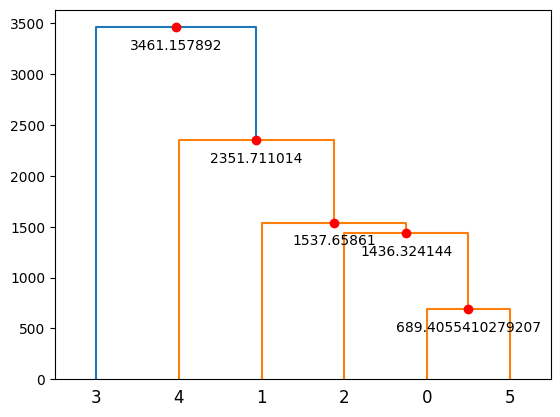

In [26]:
MakeDendogram(test_data, output2[2])

In [29]:
# from scipy.cluster import hierarchy as scipy_hierarchy


# temp = scipy_hierarchy.linkage(test_data, 'ward')
# plt.figure()
# dn = scipy_hierarchy.dendrogram(temp)

# for i, d in zip(dn['icoord'], dn['dcoord']):
#     x = 0.5 * sum(i[1:3])
#     y = d[1]
#     plt.plot(x, y, 'ro')
#     plt.annotate(y, (x, y), xytext=(0, -8),
#                     textcoords='offset points',
#                     va='top', ha='center')